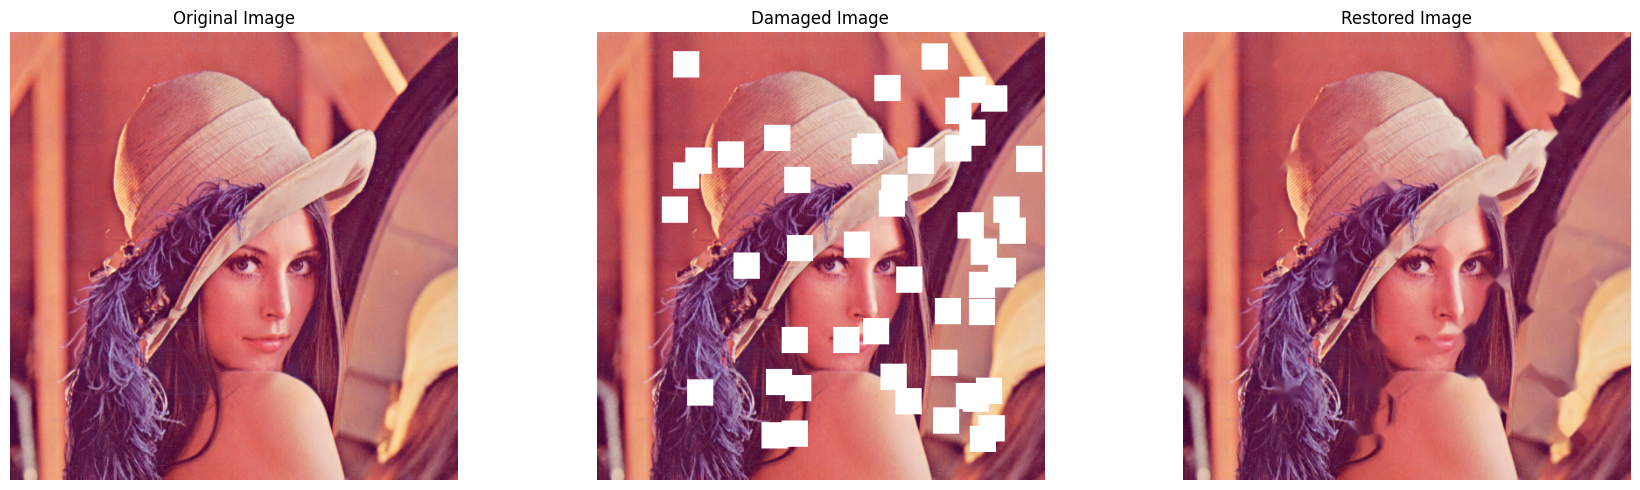

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load Lena image (uploaded earlier)
img = cv2.imread('/content/Lena_image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Function to add random white spot damage
def add_heavy_damage(image, num_spots=100, spot_size=10):
    damaged = image.copy()
    h, w, _ = image.shape
    for _ in range(num_spots):
        x = np.random.randint(spot_size, w - spot_size)
        y = np.random.randint(spot_size, h - spot_size)
        damaged[y - spot_size:y + spot_size, x - spot_size:x + spot_size] = [255, 255, 255]
    return damaged

# Step 1: Simulate heavy damage
damaged_img = add_heavy_damage(img, num_spots=50, spot_size=15)

# Step 2: Create mask for the damaged white areas
gray_damaged = cv2.cvtColor(damaged_img, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(gray_damaged, 240, 255, cv2.THRESH_BINARY)

# Step 3: Inpaint the image
restored_img = cv2.inpaint(damaged_img, mask, 3, cv2.INPAINT_TELEA)

# Step 4: Show results
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Damaged Image")
plt.imshow(damaged_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Restored Image")
plt.imshow(restored_img)
plt.axis('off')

plt.tight_layout()
plt.show()

✅ Image stitching successful!


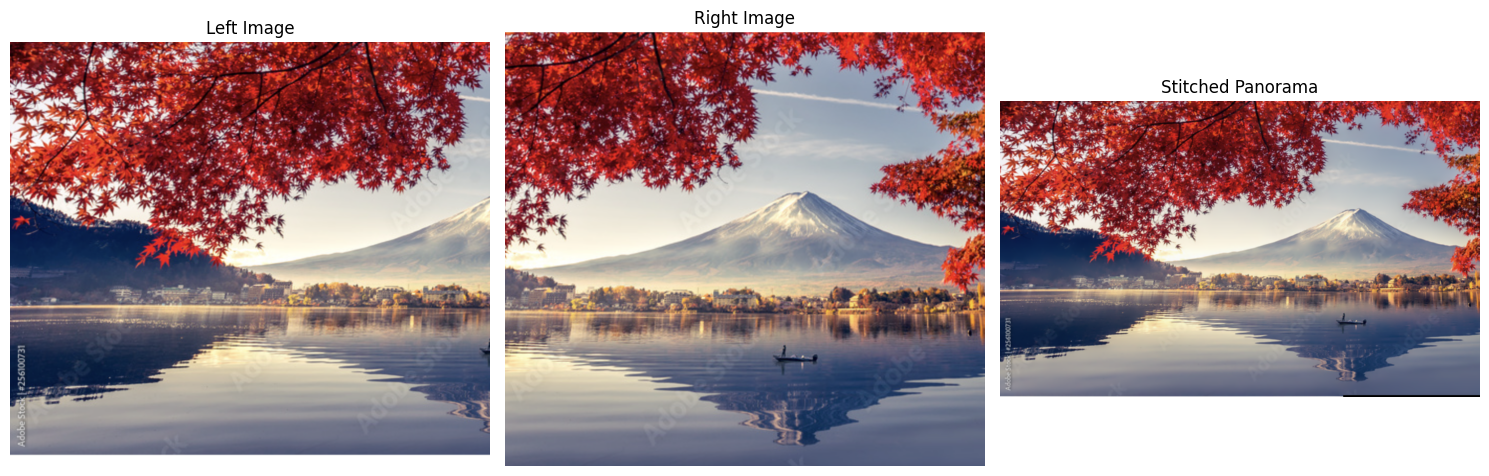

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Read the input images (ensure they are in the same folder)
img1 = cv2.imread("/content/img1.png")   # <-- change filename
img2 = cv2.imread("/content/img2.png")  # <-- change filename

# Convert BGR to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Create stitcher object (OpenCV version check)
try:
    stitcher = cv2.Stitcher_create()
except:
    stitcher = cv2.createStitcher()

# Stitch images
status, stitched = stitcher.stitch([img1, img2])

if status == cv2.Stitcher_OK:
    print("✅ Image stitching successful!")
    stitched_rgb = cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB)

    # Plot results
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.title("Left Image"); plt.imshow(img1_rgb); plt.axis('off')
    plt.subplot(1,3,2); plt.title("Right Image"); plt.imshow(img2_rgb); plt.axis('off')
    plt.subplot(1,3,3); plt.title("Stitched Panorama"); plt.imshow(stitched_rgb); plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("❌ Stitching failed. Status code:", status)


✅ Number of good matches after filtering: 20
📐 Rotation Matrix (R):
 [[-0.92437914  0.22311418 -0.30942408]
 [-0.07350978 -0.90010463 -0.42942748]
 [-0.37432541 -0.37420811  0.84843902]]
🚀 Translation Vector (t):
 [[ 0.08794118]
 [-0.08460207]
 [ 0.99252649]]


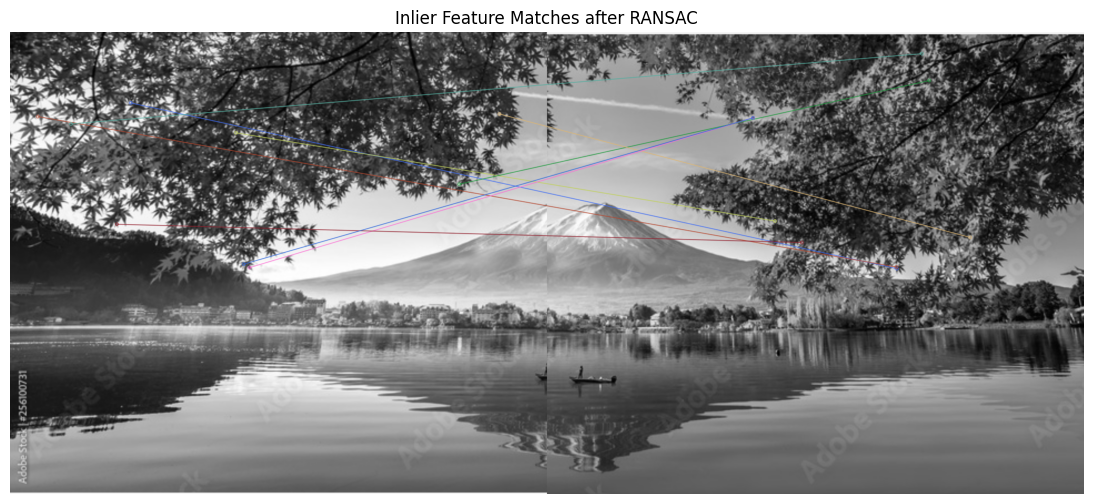

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two images (grayscale)
img1 = cv2.imread("/content/img1.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/content/img2.png", cv2.IMREAD_GRAYSCALE)

# Check image load
if img1 is None or img2 is None:
    raise ValueError("Make sure both images are uploaded and file paths are correct!")

# Step 1: ORB keypoint detection
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Step 2: Feature matching (Brute-force with Hamming distance)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1, des2, k=2)

# Step 3: Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"✅ Number of good matches after filtering: {len(good_matches)}")

# Step 4: Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Step 5: Estimate Fundamental Matrix (with RANSAC)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

# Step 6: Assume camera intrinsics matrix (K)
K = np.array([[800, 0, img1.shape[1] / 2],
              [0, 800, img1.shape[0] / 2],
              [0, 0, 1]])  # Focal length & center — tune based on actual camera if known

# Step 7: Essential Matrix
E, _ = cv2.findEssentialMat(pts1_inliers, pts2_inliers, K)

# Step 8: Recover relative pose (R, t)
_, R, t, _ = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

# Step 9: Print motion
print("📐 Rotation Matrix (R):\n", R)
print("🚀 Translation Vector (t):\n", t)

# Step 10: Draw matches (inliers only)
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, [good_matches[i] for i in range(len(mask)) if mask[i]], None, flags=2)

plt.figure(figsize=(18, 6))
plt.title("Inlier Feature Matches after RANSAC")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load CIFAR-10
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Normalize
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Resize images if needed (here kept as 32x32)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Add noise to images
def add_noise(images):
    noisy_imgs = []
    for img in images:
        img = random_noise(img, mode='gaussian', var=0.01)
        img = random_noise(img, mode='s&p', amount=0.02)
        noisy_imgs.append(img)
    return np.clip(np.array(noisy_imgs), 0., 1.)

x_train_noisy = add_noise(x_train[:10000])
x_test_noisy = add_noise(x_test[:1000])


In [ ]:
# Define autoencoder
def build_autoencoder():
    model = models.Sequential()

    # Encoder
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mse')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
📈 PSNR values for first 10 samples: [np.float64(14.128123030521566), np.float64(9.637256333616556), np.float64(11.678837849813393), np.float64(12.076066851346706), np.float64(14.958625634395217), np.float64(13.571099776171081), np.float64(9.71037513040791), np.float64(12.77707674599478), np.float64(13.452371414721666), np.float64(11.700495779838725)]
🔎 Mean PSNR: 12.36903285468276


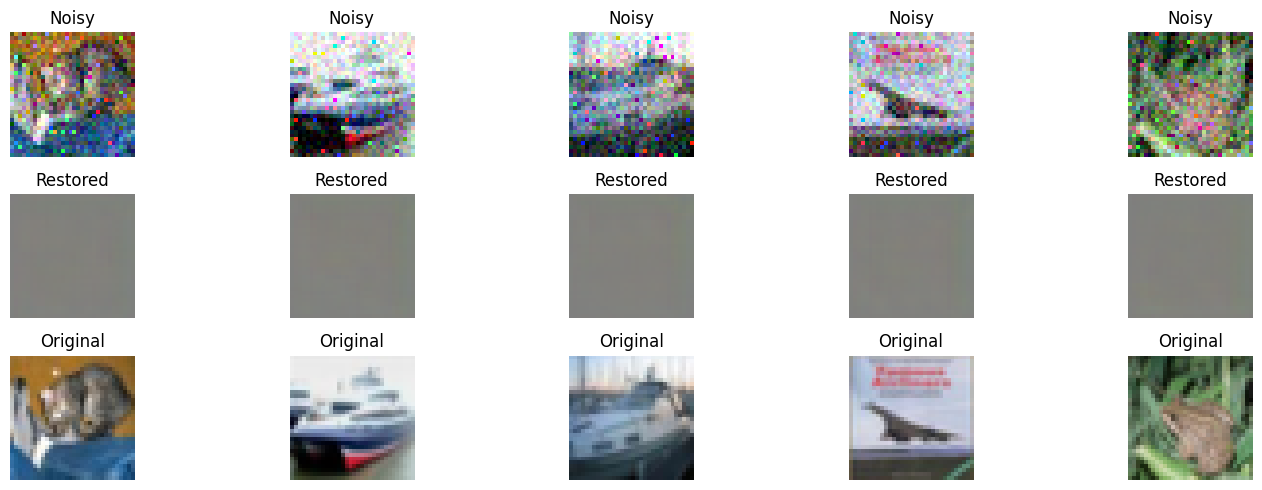

In [ ]:
# Predict
x_decoded = autoencoder.predict(x_test_noisy)

# Evaluate with PSNR
psnr_values = [psnr(x_test[i], x_decoded[i]) for i in range(10)]
print("📈 PSNR values for first 10 samples:", psnr_values)
print("🔎 Mean PSNR:", np.mean(psnr_values))

# Visualize results
n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # Noisy
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_decoded[i])
    plt.title("Restored")
    plt.axis('off')

    # Original
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorflow pandas numpy matplotlib kagglehub


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_v1
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_v2
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_v3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import kagglehub

# Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("gauravduttakiit/dog-classification-mobilenet-v2")
print("Dataset downloaded to:", dataset_path)

# Paths to training and testing data
train_csv_path = os.path.join(dataset_path, 'train.csv')
test_csv_path = os.path.join(dataset_path, 'test.csv')
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = train_df['breed'].nunique()

# Data generators
def create_data_generators(preprocess_input):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        rotation_range=20
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col='id',
        y_col='breed',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=42
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col='id',
        y_col='breed',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=42
    )

    return train_generator, validation_generator

# Model builder
def build_model(base_model, preprocess_input):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dictionary to store results
results = {}

# MobileNet V1
print("Training MobileNet V1...")
train_gen_v1, val_gen_v1 = create_data_generators(preprocess_input_v1)
base_model_v1 = MobileNet(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
model_v1 = build_model(base_model_v1, preprocess_input_v1)
history_v1 = model_v1.fit(train_gen_v1, validation_data=val_gen_v1, epochs=EPOCHS)
results['MobileNet V1'] = history_v1

# MobileNet V2
print("Training MobileNet V2...")
train_gen_v2, val_gen_v2 = create_data_generators(preprocess_input_v2)
base_model_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
model_v2 = build_model(base_model_v2, preprocess_input_v2)
history_v2 = model_v2.fit(train_gen_v2, validation_data=val_gen_v2, epochs=EPOCHS)
results['MobileNet V2'] = history_v2

# MobileNet V3 Small
print("Training MobileNet V3 Small...")
train_gen_v3, val_gen_v3 = create_data_generators(preprocess_input_v3)
base_model_v3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
model_v3 = build_model(base_model_v3, preprocess_input_v3)
history_v3 = model_v3.fit(train_gen_v3, validation_data=val_gen_v3, epochs=EPOCHS)
results['MobileNet V3'] = history_v3

# Plotting results
for model_name, history in results.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
